### Web Scraping and Automation

In [1]:
# Importing needed libraries
import os
import json

# Data analysis
import pandas as pd

# Data visualisations
import seaborn as sns
import matplotlib as plt

# Time management
import datetime
import time

# Web Scraping
from seleniumwire import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

print('Needed Libraries Imported Correctly')

Needed Libraries Imported Correctly


In [2]:
# Create the driver with selenium using Chrome
options = webdriver.ChromeOptions()
options.add_argument('--headless=new')
options.add_argument('window-size=1920x1080')
options.add_argument("disable-gpu")
options.add_argument('--user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36 OPR/114.0.0.0"')

In [3]:
# ? Venezuela central bank link
bcv = 'https://www.bcv.org.ve' 
# ? Colombia central bank link
banrep = 'https://www.banrep.gov.co/es'
# ? Chile central bank link
bcentralcl = 'https://www.bcentral.cl/inicio'
# ? Uruguay central bank link
bcu = 'https://www.bcu.gub.uy/Paginas/Default.aspx'

# ? Mexico central bank API
banxico = 'https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF43718/datos/oportuno'
bmx_token='2071d60416fb5ea9393e1a37d1da9564678203c766c4222bc03b12c2a1e34142'
# ? Argentina central bank API
bcra = 'https://api.bcra.gob.ar/estadisticascambiarias/v1.0/Cotizaciones/USD'
# ? Peru central bank API
bcrp = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04638PD/json'

In [4]:
def peso_mex(): # * Request Mexico Bank API to extract the dolar exchange rate 
    def interceptor(request):
        request.headers['Accept'] = 'application/json'
        request.headers['Bmx-Token'] = bmx_token
    try:
        driver = webdriver.Chrome(options=options)
        driver.request_interceptor = interceptor
        driver.get(banxico)
        page = driver.page_source
        soup = BeautifulSoup(page, 'html.parser')
        raw_json = soup.get_text()
        driver.close()
        
        data = json.loads(raw_json)
        pesomx = float(data['bmx']['series'][0]['datos'][0]['dato'])
    except Exception: # ? It seems that Banxico API is off during weekends so this ensure data collection continues
        pesomx = None;
        driver = webdriver.Chrome(options=options)
        driver.get("https://www.banxico.org.mx")    
        page = driver.page_source
        soup = BeautifulSoup(page, 'html.parser')
        driver.close()
                
        pesomx = soup.find(id='vFIX')
        pesomx = pesomx.find('span', class_='valor').text.strip()
        pesomx = float(pesomx.replace(',','.'))
    return pesomx

def peso_arg(): # * Request Argentina Bank API to extract the dolar exchange rate 
    driver = webdriver.Chrome(options=options)
    driver.get(bcra)
    page = driver.page_source
    soup = BeautifulSoup(page, 'html.parser')
    raw_json = soup.get_text()
    driver.close()
    
    data = json.loads(raw_json)
    pesoar = data['results'][0]['detalle'][0]['tipoCotizacion']
    return pesoar

def sol_per(): # * Request Peru Bank API to extract the dolar exchange rate 
    driver = webdriver.Chrome(options=options)
    driver.get(bcrp)
    page = driver.page_source
    soup = BeautifulSoup(page, 'html.parser')
    raw_json = soup.get_text()
    driver.close()
        
    data = json.loads(raw_json)
    solpr = float(data['periods'][-1]['values'][0])
    return solpr

def peso_col(): # * Request colombia bank website to scrap the public dolar exchange rate
    driver = webdriver.Chrome(options=options)
    driver.get(banrep)
    time.sleep(5)
    page = driver.page_source
    soup = BeautifulSoup(page, 'html.parser')
    driver.close()
    
    peso_cl = soup.find_all('div', class_="indicator__value")[4]
    peso_cl = peso_cl.find('a').text.strip()
    peso_cl = peso_cl.replace('.','')
    peso_cl = peso_cl.replace(',','.')
    peso_cl = float(peso_cl)
    return peso_cl

def bolivar_vz(): # * Request venezuela bank website to scrap the public dolar exchange rate
    driver = webdriver.Chrome(options=options)
    driver.get(bcv)
    #time.sleep(5)
    page = driver.page_source
    soup = BeautifulSoup(page, 'html.parser')
    driver.close()
    
    bs = soup.find_all("strong")[6].text.strip()
    bs = bs.replace(",", ".")
    bs = float(bs)
    return bs

def peso_chl(): # * Request chile bank website to scrap the public dolar exchange rate
    driver = webdriver.Chrome(options=options)
    driver.get(bcentralcl)
    page = driver.page_source
    soup = BeautifulSoup(page, 'html.parser')
    driver.close()
            
    pesochl = soup.find_all('p', class_='basic-text fs-2 f-opensans-bold text-center c-blue-nb-2')[2].text.strip()[1:]
    pesochl = pesochl.replace(',','.')
    for char in pesochl:
        if char == '/': 
            pesochl = pesochl[:pesochl.find('/')]
    pesochl = float(pesochl.strip())
    return pesochl

def peso_ur(): # * Request uruguay bank website to scrap the public dolar exchange rate
    driver = webdriver.Chrome(options=options)
    driver.get(bcu)
    #time.sleep(5)
    page = driver.page_source
    soup = BeautifulSoup(page, 'html.parser')
    driver.close()
            
    pesour = soup.find(id='2225')
    pesour = pesour.find('div', class_='info')
    pesour = pesour.find_all('span')[1].text.strip()
    pesour = float(pesour.replace(',','.'))
    return pesour

In [5]:
def check_price(): # * Main Method to ask the information and append to a .csv files
    today = datetime.date.today() # ? Time stamp of the day
    
    headers = ["usd_exchange_rate_venezuela", "usd_exchange_rate_colombia", "usd_exchange_rate_mexico", "usd_exchange_rate_argentina", 
                "usd_exchange_rate_chile", "usd_exchange_rate_uruguay", "usd_exchange_rate_peru", "date"]
    data = [bolivar_vz(), peso_col(), peso_mex(), peso_arg(), peso_chl(), peso_ur(), sol_per(), today]

    df = pd.DataFrame([data], columns=[headers])
    
    if not os.path.isfile(r"usd_exchange_rate.csv"): # * Create file or append information
        df.to_csv(r"usd_exchange_rate.csv", header='column_names', index=False)
    else:
        df.to_csv(r"usd_exchange_rate.csv", mode='a', header=False, index=False)

In [11]:
# Loop each day through the main method
while True:
    print("Running loop")
    try:
        check_price()
    except Exception as err:
        if err != KeyboardInterrupt:
            print(f"Error Detected: {err}. Repeating loop")
            continue;
        else:
            break;
    print("Exiting loop")
    #break; # Testing break to avoid looping while testing
    time.sleep(86400)

Running loop
Exiting loop


### Analysis and Visualizations

In [13]:
# ? Reading the dataset
df2 = pd.read_csv(r"usd_exchange_rate.csv")
df2

,usd_exchange_rate_venezuela,usd_exchange_rate_colombia,usd_exchange_rate_mexico,usd_exchange_rate_argentina,usd_exchange_rate_chile,usd_exchange_rate_uruguay,usd_exchange_rate_peru,date
0,48.7903,4396.52,20.2275,1015.5,971.65,43.543,3.730833,2024-12-08
1,48.7903,4396.52,20.2275,1015.5,971.62,43.543,3.730833,2024-12-09
2,48.8695,4379.71,20.1547,1016.5,969.92,43.726,3.730833,2024-12-10
3,49.1111,4379.71,20.2485,1017.0,972.43,44.028,3.721833,2024-12-11
4,49.4757,4361.22,20.1647,1017.5,975.81,44.433,3.721833,2024-12-12
5,49.9068,4361.22,20.1647,1019.0,975.67,44.281,3.720833,2024-12-13
6,50.3319,4341.32,20.1420,1020.5,975.67,44.558,3.720833,2024-12-14
7,50.3319,4341.32,20.1420,1020.5,975.67,44.558,3.720833,2024-12-15


In [15]:
# ? Grouping by date
df3 = df2.groupby('date').mean()
df3

,usd_exchange_rate_venezuela,usd_exchange_rate_colombia,usd_exchange_rate_mexico,usd_exchange_rate_argentina,usd_exchange_rate_chile,usd_exchange_rate_uruguay,usd_exchange_rate_peru
date,,,,,,,
2024-12-08,48.7903,4396.52,20.2275,1015.5,971.65,43.543,3.730833
2024-12-09,48.7903,4396.52,20.2275,1015.5,971.62,43.543,3.730833
2024-12-10,48.8695,4379.71,20.1547,1016.5,969.92,43.726,3.730833
2024-12-11,49.1111,4379.71,20.2485,1017.0,972.43,44.028,3.721833
2024-12-12,49.4757,4361.22,20.1647,1017.5,975.81,44.433,3.721833
2024-12-13,49.9068,4361.22,20.1647,1019.0,975.67,44.281,3.720833
2024-12-14,50.3319,4341.32,20.1420,1020.5,975.67,44.558,3.720833
2024-12-15,50.3319,4341.32,20.1420,1020.5,975.67,44.558,3.720833


In [17]:
# ? Stack the info to have the headers as columns
df4 = df3.stack()
df4

date                                   
2024-12-08  usd_exchange_rate_venezuela      48.790300
            usd_exchange_rate_colombia     4396.520000
            usd_exchange_rate_mexico         20.227500
            usd_exchange_rate_argentina    1015.500000
            usd_exchange_rate_chile         971.650000
            usd_exchange_rate_uruguay        43.543000
            usd_exchange_rate_peru            3.730833
2024-12-09  usd_exchange_rate_venezuela      48.790300
            usd_exchange_rate_colombia     4396.520000
            usd_exchange_rate_mexico         20.227500
            usd_exchange_rate_argentina    1015.500000
            usd_exchange_rate_chile         971.620000
            usd_exchange_rate_uruguay        43.543000
            usd_exchange_rate_peru            3.730833
2024-12-10  usd_exchange_rate_venezuela      48.869500
            usd_exchange_rate_colombia     4379.710000
            usd_exchange_rate_mexico         20.154700
            usd_exchange_

In [18]:
# ? Converting into data frame
df5 = df4.to_frame(name='value')
df5

value
date                                               
2024-12-08 usd_exchange_rate_venezuela    48.790300
           usd_exchange_rate_colombia   4396.520000
           usd_exchange_rate_mexico       20.227500
           usd_exchange_rate_argentina  1015.500000
           usd_exchange_rate_chile       971.650000
           usd_exchange_rate_uruguay      43.543000
           usd_exchange_rate_peru          3.730833
2024-12-09 usd_exchange_rate_venezuela    48.790300
           usd_exchange_rate_colombia   4396.520000
           usd_exchange_rate_mexico       20.227500
           usd_exchange_rate_argentina  1015.500000
           usd_exchange_rate_chile       971.620000
           usd_exchange_rate_uruguay      43.543000
           usd_exchange_rate_peru          3.730833
2024-12-10 usd_exchange_rate_venezuela    48.869500
           usd_exchange_rate_colombia   4379.710000
           usd_exchange_rate_mexico       20.154700
           usd_exchange_rate_argentina  1016.500000
           usd_exchange_rate_chile       969.920000
           usd_exchange_rate_uruguay      43.726000
           usd_exchange_rate_peru          3.730833
2024-12-11 usd_exchange_rate_venezuela    49.111100
           usd_exchange_rate_colombia   4379.710000
           usd_exchange_rate_mexico       20.248500
           usd_exchange_rate_argentina  1017.000000
           usd_exchange_rate_chile       972.430000
           usd_exchange_rate_uruguay      44.028000
           usd_exchange_rate_peru          3.721833
2024-12-12 usd_exchange_rate_venezuela    49.475700
           usd_exchange_rate_colombia   4361.220000
           usd_exchange_rate_mexico       20.164700
           usd_exchange_rate_argentina  1017.500000
           usd_exchange_rate_chile       975.810000
           usd_exchange_rate_uruguay      44.433000
           usd_exchange_rate_peru          3.721833
2024-12-13 usd_exchange_rate_venezuela    49.906800
           usd_exchange_rate_colombia   4361.220000
           usd_exchange_rate_mexico       20.164700
           usd_exchange_rate_argentina  1019.000000
           usd_exchange_rate_chile       975.670000
           usd_exchange_rate_uruguay      44.281000
           usd_exchange_rate_peru          3.720833
2024-12-14 usd_exchange_rate_venezuela    50.331900
           usd_exchange_rate_colombia   4341.320000
           usd_exchange_rate_mexico       20.142000
           usd_exchange_rate_argentina  1020.500000
           usd_exchange_rate_chile       975.670000
           usd_exchange_rate_uruguay      44.558000
           usd_exchange_rate_peru          3.720833
2024-12-15 usd_exchange_rate_venezuela    50.331900
           usd_exchange_rate_colombia   4341.320000
           usd_exchange_rate_mexico       20.142000
           usd_exchange_rate_argentina  1020.500000
           usd_exchange_rate_chile       975.670000
           usd_exchange_rate_uruguay      44.558000
           usd_exchange_rate_peru          3.720833

In [19]:
df5.count()

value    56
dtype: int64

In [21]:
# ? Setting and resetting the index
index = pd.Index(range(21))

df6 = df5.reset_index()
df6

,date,level_1,value
0,2024-12-08,usd_exchange_rate_venezuela,48.790300
1,2024-12-08,usd_exchange_rate_colombia,4396.520000
2,2024-12-08,usd_exchange_rate_mexico,20.227500
3,2024-12-08,usd_exchange_rate_argentina,1015.500000
4,2024-12-08,usd_exchange_rate_chile,971.650000
5,2024-12-08,usd_exchange_rate_uruguay,43.543000
6,2024-12-08,usd_exchange_rate_peru,3.730833
7,2024-12-09,usd_exchange_rate_venezuela,48.790300
8,2024-12-09,usd_exchange_rate_colombia,4396.520000
9,2024-12-09,usd_exchange_rate_mexico,20.227500


In [24]:
# ? Rename the columns
df7 = df6.rename(columns={'level_1': 'exchange_country'})
df7

,date,exchange_country,value
0,2024-12-08,usd_exchange_rate_venezuela,48.790300
1,2024-12-08,usd_exchange_rate_colombia,4396.520000
2,2024-12-08,usd_exchange_rate_mexico,20.227500
3,2024-12-08,usd_exchange_rate_argentina,1015.500000
4,2024-12-08,usd_exchange_rate_chile,971.650000
5,2024-12-08,usd_exchange_rate_uruguay,43.543000
6,2024-12-08,usd_exchange_rate_peru,3.730833
7,2024-12-09,usd_exchange_rate_venezuela,48.790300
8,2024-12-09,usd_exchange_rate_colombia,4396.520000
9,2024-12-09,usd_exchange_rate_mexico,20.227500


In [25]:
# ? Following Venezuela exchange rate
df8 = df2[['usd_exchange_rate_venezuela', 'date']]
df8

,usd_exchange_rate_venezuela,date
0,48.7903,2024-12-08
1,48.7903,2024-12-09
2,48.8695,2024-12-10
3,49.1111,2024-12-11
4,49.4757,2024-12-12
5,49.9068,2024-12-13
6,50.3319,2024-12-14
7,50.3319,2024-12-15


In [26]:
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (15,7)

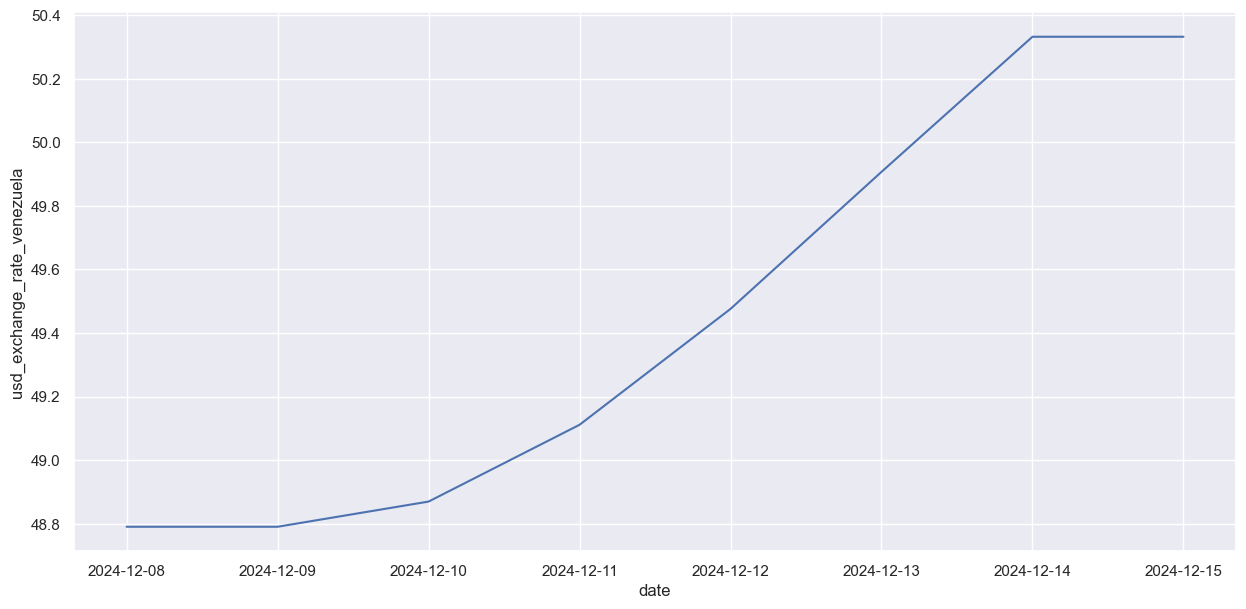

In [27]:
# Line visualisation of venezuela exchange rate
sns.lineplot(x='date', y='usd_exchange_rate_venezuela', data = df8)
plt.pyplot.show()

In [28]:
# ? Sorting by country and date to get percentage change
df9 = df7
df9 = df9.sort_values(by=['exchange_country', 'date'])
df9 = df9.reset_index(drop=True)

In [30]:
# ? Getting percentage change and converting into data frame
df10 = df9.groupby(['exchange_country'])['value'].apply(lambda x: round(((x-x.shift(1))/x.shift(1))*100,4)).to_frame(name='percent_change')

In [32]:
# filling NaN with 0
df10.fillna(0.0000, inplace=True)
df10

percent_change
exchange_country                              
usd_exchange_rate_argentina 0           0.0000
                            1           0.0000
                            2           0.0985
                            3           0.0492
                            4           0.0492
                            5           0.1474
                            6           0.1472
                            7           0.0000
usd_exchange_rate_chile     8           0.0000
                            9          -0.0031
                            10         -0.1750
                            11          0.2588
                            12          0.3476
                            13         -0.0143
                            14          0.0000
                            15          0.0000
usd_exchange_rate_colombia  16          0.0000
                            17          0.0000
                            18         -0.3823
                            19          0.0000
                            20         -0.4222
                            21          0.0000
                            22         -0.4563
                            23          0.0000
usd_exchange_rate_mexico    24          0.0000
                            25          0.0000
                            26         -0.3599
                            27          0.4654
                            28         -0.4139
                            29          0.0000
                            30         -0.1126
                            31          0.0000
usd_exchange_rate_peru      32          0.0000
                            33          0.0000
                            34          0.0000
                            35         -0.2412
                            36          0.0000
                            37         -0.0269
                            38          0.0000
                            39          0.0000
usd_exchange_rate_uruguay   40          0.0000
                            41          0.0000
                            42          0.4203
                            43          0.6907
                            44          0.9199
                            45         -0.3421
                            46          0.6256
                            47          0.0000
usd_exchange_rate_venezuela 48          0.0000
                            49          0.0000
                            50          0.1623
                            51          0.4944
                            52          0.7424
                            53          0.8713
                            54          0.8518
                            55          0.0000

In [34]:
df10.count()

percent_change    56
dtype: int64

In [36]:
# ? Preparing for concat
index = pd.Index(range(49))

df11 = df10.reset_index()
df11 = df11.drop(columns='level_1')
df11

,exchange_country,percent_change
0,usd_exchange_rate_argentina,0.0000
1,usd_exchange_rate_argentina,0.0000
2,usd_exchange_rate_argentina,0.0985
3,usd_exchange_rate_argentina,0.0492
4,usd_exchange_rate_argentina,0.0492
5,usd_exchange_rate_argentina,0.1474
6,usd_exchange_rate_argentina,0.1472
7,usd_exchange_rate_argentina,0.0000
8,usd_exchange_rate_chile,0.0000
9,usd_exchange_rate_chile,-0.0031


In [37]:
df12 = pd.concat([df9, df11], axis=1, join='inner') # ? Concat both data into one
df12 = df12.loc[:, ~df12.columns.duplicated()] # ? Remove the duplicated columns
df12

,date,exchange_country,value,percent_change
0,2024-12-08,usd_exchange_rate_argentina,1015.500000,0.0000
1,2024-12-09,usd_exchange_rate_argentina,1015.500000,0.0000
2,2024-12-10,usd_exchange_rate_argentina,1016.500000,0.0985
3,2024-12-11,usd_exchange_rate_argentina,1017.000000,0.0492
4,2024-12-12,usd_exchange_rate_argentina,1017.500000,0.0492
5,2024-12-13,usd_exchange_rate_argentina,1019.000000,0.1474
6,2024-12-14,usd_exchange_rate_argentina,1020.500000,0.1472
7,2024-12-15,usd_exchange_rate_argentina,1020.500000,0.0000
8,2024-12-08,usd_exchange_rate_chile,971.650000,0.0000
9,2024-12-09,usd_exchange_rate_chile,971.620000,-0.0031


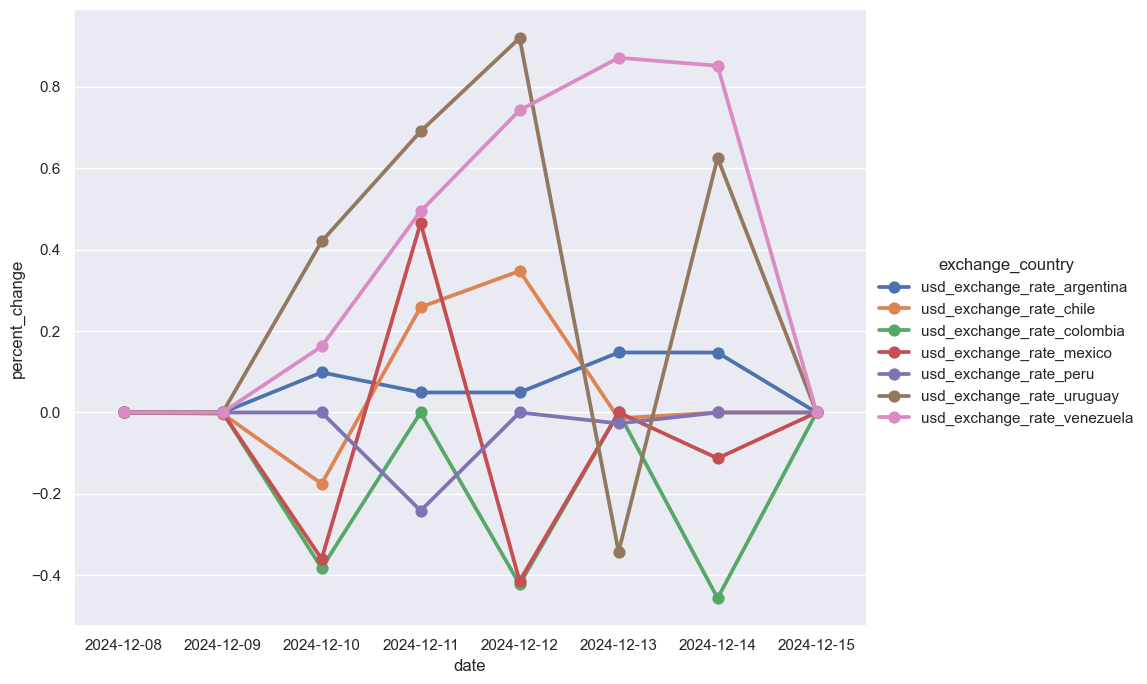

In [38]:
# Visualizating the percentage change of each country exchange rate
sns.catplot(x='date', y='percent_change', hue='exchange_country', data=df12, kind='point', height=7, aspect=1.3)